
# Joint cascade model with $E_{\rm{min}}$ handled correctly

When including the realistic energy resolution, for certain channels, this means very large energy detection uncertainties. On of the assumptions of the formalism is that a hard cut on the detected energies corresponds to a hard cut on the source energies, which is no longer true in this case. Need to edit to cope. 

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
import stan_utility
import corner

from joint_model_cascades import * 
from aeff_calculator.aeff_calculator import effective_area
from energy_conditional import EnergyConditional

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
random_seed = 19920715

## Simulation

#### Sources

Assume a predefined set of source and background component with fixed redshift, at the source population redshift threshold. This implements a *very crude* selection effect. 

In [3]:
# Use a set of sources uniform in comoving volume for a lambda-CDM universe.
with h5py.File('../data/test_SFR_pop.h5', 'r') as f:
    Ns = f['output/Ns'].value
    redshift = f['output/redshift'].value
    position = f['output/position'].value
    
# Select sources within redshift zth to mimic catalogue
zth = 1.0
selection = np.where(redshift < zth)[0]
Ns = len(selection)
redshift = np.array([redshift[_] for _ in selection])
position = np.array([position[_] for _ in selection])
unit_vector = [p / np.linalg.norm(p) for p in position]

# Add background redshift
redshift = list(redshift) + [zth]

#### Effective area
Use same effective area as in precomputation!

In [4]:
from scipy.interpolate import RectBivariateSpline

aeff = effective_area("nue_CC")

... creating effective area spline for interaction nue_CC , done!


In [5]:
# Get input for spline evaluation in Stan
p = 3  # spline degree (default in RectBivariateSpline)
xknots, yknots = aeff.spline.get_knots()
c = aeff.spline.get_coeffs()

xknots = np.unique(xknots)
yknots = np.unique(yknots)
Nx = len(xknots)+p-1 
Ny = len(yknots)+p-1 
c = c.reshape(Nx, Ny)

# Maximum of the effective area, to scale 
aeff_max = max(10**aeff.aeff_vals) # m^2

#### Precomputed exposure integral
See `precomputation.ipynb` for info.

In [6]:
# Get precomputed eps factor
with h5py.File('data/precomputed_integral.h5', 'r') as f:
    alpha_grid = f['alpha_grid'].value
    integral_grid = f['integral_grid'].value

In [7]:
# For sim
with h5py.File('data/precomputed_integral_5e3.h5', 'r') as f:
    alpha_grid_sim = f['alpha_grid'].value
    integral_grid_sim = f['integral_grid'].value

#### Energy resolution
See `conditionals.ipynb`.

In [8]:
# Nue_CC
#cond_file = ('data/conditional_2D_nue_CC_simulation_'
#             +'gamma_1.0_lEmin_3.0_lEmax_7.0_fixed.txt')

# Nue_NC
cond_file = ('data/conditional_2D_nue_NC_simulation_' +
             'gamma_1.0_lEmin_3.0_lEmax_7.0_fixed.txt')
energy_conditional = EnergyConditional(cond_file)

In [9]:
# Get input for spline evaluation in Stan
E_p = 1  # spline degree 
E_xknots, E_yknots = energy_conditional.spline.get_knots()
E_xknots = np.unique(E_xknots)
E_yknots = np.unique(E_yknots)
E_Nx = len(E_xknots)+E_p-1 
E_Ny = len(E_yknots)+E_p-1 
E_c = energy_conditional.spline.get_coeffs()
E_c = E_c.reshape(E_Nx, E_Ny)

#### Input parameters

Now define all input parameters, including those that we will fit for.

In [10]:
# Prepare simulation inputs that are defined above
sim_input = {}

# Sources
sim_input['Ns'] = Ns
sim_input['z'] = redshift
sim_input['D'] = [luminosity_distance(z) for z in redshift[:-1]] # Mpc
sim_input['varpi'] = unit_vector

# Exposure integral interpolation grid
sim_input['Ngrid'] = len(alpha_grid_sim)
sim_input['alpha_grid'] = alpha_grid_sim
sim_input['integral_grid'] = integral_grid_sim

# Aeff Spline
sim_input['p'] = p
sim_input['Lknots_x'] = len(xknots)
sim_input['Lknots_y'] = len(yknots)
sim_input['xknots'] = xknots
sim_input['yknots'] = yknots
sim_input['c'] = c
sim_input['aeff_max'] = aeff_max

# Eres spline
sim_input['E_p'] = E_p
sim_input['E_Lknots_x'] = len(E_xknots)
sim_input['E_Lknots_y'] = len(E_yknots)
sim_input['E_xknots'] = E_xknots
sim_input['E_yknots'] = E_yknots
sim_input['E_c'] = E_c

In [11]:
# Define simulation parameters

# Energies
sim_input['alpha'] = 2.0
sim_input['Emin'] = 5.0e3 # Emin_sim
Emin = 1e4 # GeV
E_scale = (Emin / sim_input['Emin'])**(1-sim_input['alpha'])
sim_input['f_E'] = 0.1 

# Reconstruction 
sim_input['kappa'] = 100 # ~10 deg for cascades

# Associated fraction  (derived paramaters, but easier to define this way)
total_flux = 5e2 # m^-2 yr^-1
f = 0.5

sim_input['T'] = 1 # yr
sim_input['F0'] = (1 - f) * total_flux # m^-2 yr^-1
sim_input['Q'] = ( (f*total_flux) / (sum([1 / (4*np.pi * (d*Mpc_to_m)**2) 
                                          for d in sim_input['D']])) ) # yr^-1 
print('F0:', sim_input['F0'])

F0: 250.0


#### Run simulation

In [12]:
# Compile Stan model
sim = stan_utility.compile_model(filename = 'stan/joint_cascade_sim_Eth.stan', 
                                 model_name = 'Eth_sim', include_paths = 'stan/')

Using cached StanModel


In [13]:
# Simulate
simulation = sim.sampling(data=sim_input, iter=1, chains=1, 
                          algorithm="Fixed_param", seed=random_seed)

In [14]:
# Extract output
from fancy.interfaces.stan import Direction
from fancy.plotting import AllSkyMap

# Energies
Esrc = simulation.extract(['Esrc'])['Esrc'][0]
E = simulation.extract(['E'])['E'][0]
Edet = simulation.extract(['Edet'])['Edet'][0]
selection = np.where(Edet >= Emin)[0]
Edet = [Edet[_] for _ in selection]
print(len(Edet), 'events above threshold energy!')

# Arrival directions
event = simulation.extract(['event'])['event'][0]
event = [event[_] for _ in selection]
event = Direction(event)
e_ra = event.d.icrs.ra.rad
e_dec = event.d.icrs.dec.rad

source = Direction(unit_vector)
s_ra = source.d.icrs.ra.rad
s_dec = source.d.icrs.dec.rad

102 events above threshold energy!


/Users/fran/projects/bayes/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [15]:
# Labels
lam = simulation.extract(['lambda'])['lambda'][0] - 1
Nc = Ns
label_cmap = plt.cm.get_cmap('plasma', Nc+1)

lam = list(lam)
Nsrc = sum([lam.count(_) for _ in range(int(Nc))])
Nbg = lam.count(Nc)
print('Nsrc: ', Nsrc)
print('Nbg: ', Nbg)
print('w_bg: ', Nbg / (Nbg+Nsrc))

Nsrc:  62
Nbg:  51
w_bg:  0.45132743362831856


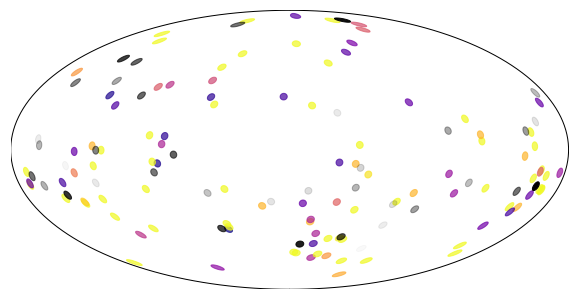

In [16]:
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots()
fig.set_size_inches((10, 8))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);
for r, d, l in zip(e_ra, e_dec, lam):
    color = label_cmap.colors[int(l)]
    skymap.tissot(np.rad2deg(r), np.rad2deg(d), 2, 30, color = color, alpha = 0.7)
norm = max([1 - _/zth for _ in redshift])
for r, d, z in zip(s_ra, s_dec, redshift):
    skymap.tissot(np.rad2deg(r), np.rad2deg(d), 2, 30, color = 'black', 
                  alpha = (1 - z/zth)/norm)

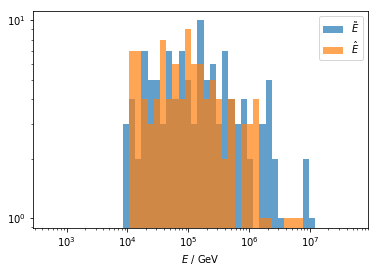

In [17]:
# Plot energies
Emin = sim_input['Emin']
bins = np.logspace(np.log(Emin/10), np.log(1E+4*Emin), base = np.e)

fig, ax = plt.subplots()
ax.hist(Esrc, bins=bins, label='$\\tilde{E}$', alpha=0.7);
ax.hist(Edet, bins=bins, label='$\hat{E}$', alpha=0.7);
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / GeV')
ax.legend();

## Fitting the model

In [18]:
# For convenience
energy_conditional.get_norm_spline_Edet()

In [19]:
# Precompute interpolation grids for energy resolution
prob_grid = []
log10_E_grid = []
for lEdet in np.log10(Edet):
    prob_i = []
    log10_E_grid_i = np.linspace(4.0, 7, 100)
    # log10_E_grid_i = np.linspace(lEdet-0.5, lEdet+0.5) # for Nue_CC!
    for lE in log10_E_grid_i:
        prob_i.append(energy_conditional.norm_spline(lE, lEdet)[0][0])
    prob_grid.append(prob_i)
    log10_E_grid.append(log10_E_grid_i)

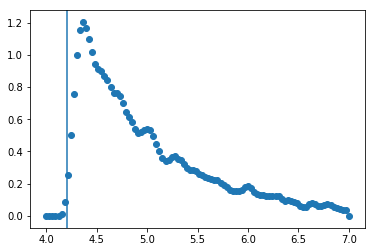

In [20]:
fig, ax = plt.subplots()
i=16
ax.scatter(log10_E_grid[i], prob_grid[i])
ax.axvline(np.log10(Edet[i]))

In [21]:
# Prepare fit inputs
fit_input = {}
fit_input['N'] = len(event.unit_vector)
fit_input['omega_det'] = event.unit_vector
fit_input['Emin'] = sim_input['Emin']
fit_input['f_E'] = sim_input['f_E']
fit_input['Edet'] = Edet
fit_input['Ns'] = Ns
fit_input['varpi'] = source.unit_vector
fit_input['D'] = sim_input['D']
fit_input['z'] = sim_input['z']
fit_input['kappa'] = sim_input['kappa']
fit_input['Ngrid'] = sim_input['Ngrid'] 
fit_input['alpha_grid'] = sim_input['alpha_grid'] 
fit_input['integral_grid'] = sim_input['integral_grid'] 
fit_input['T'] = sim_input['T']

# Spline
fit_input['p'] = sim_input['p']
fit_input['Lknots_x'] = sim_input['Lknots_x'] 
fit_input['Lknots_y'] = sim_input['Lknots_y'] 
fit_input['xknots'] = sim_input['xknots'] 
fit_input['yknots'] = sim_input['yknots'] 
fit_input['c'] = sim_input['c'] 
fit_input['aeff_max'] = sim_input['aeff_max']

# Energy interp
fit_input['E_Ngrid'] = len(prob_grid[0])
fit_input['log10_E_grid'] = log10_E_grid
fit_input['prob_grid'] = prob_grid

# Debugging
fit_input['Q_scale'] = sim_input['Q']
fit_input['F0_scale'] = sim_input['F0']

In [27]:
# Compile the model
model = stan_utility.compile_model(filename = 'stan/joint_cascade_model_Eth.stan', 
                                   model_name = 'Eth_model', 
                                   include_paths = 'stan/')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Eth_model_b101086e78c1b985102a52dc7ecaf1b4 NOW.


In [28]:
fit = model.sampling(data = fit_input, iter = 1000, chains = 4, seed = random_seed)

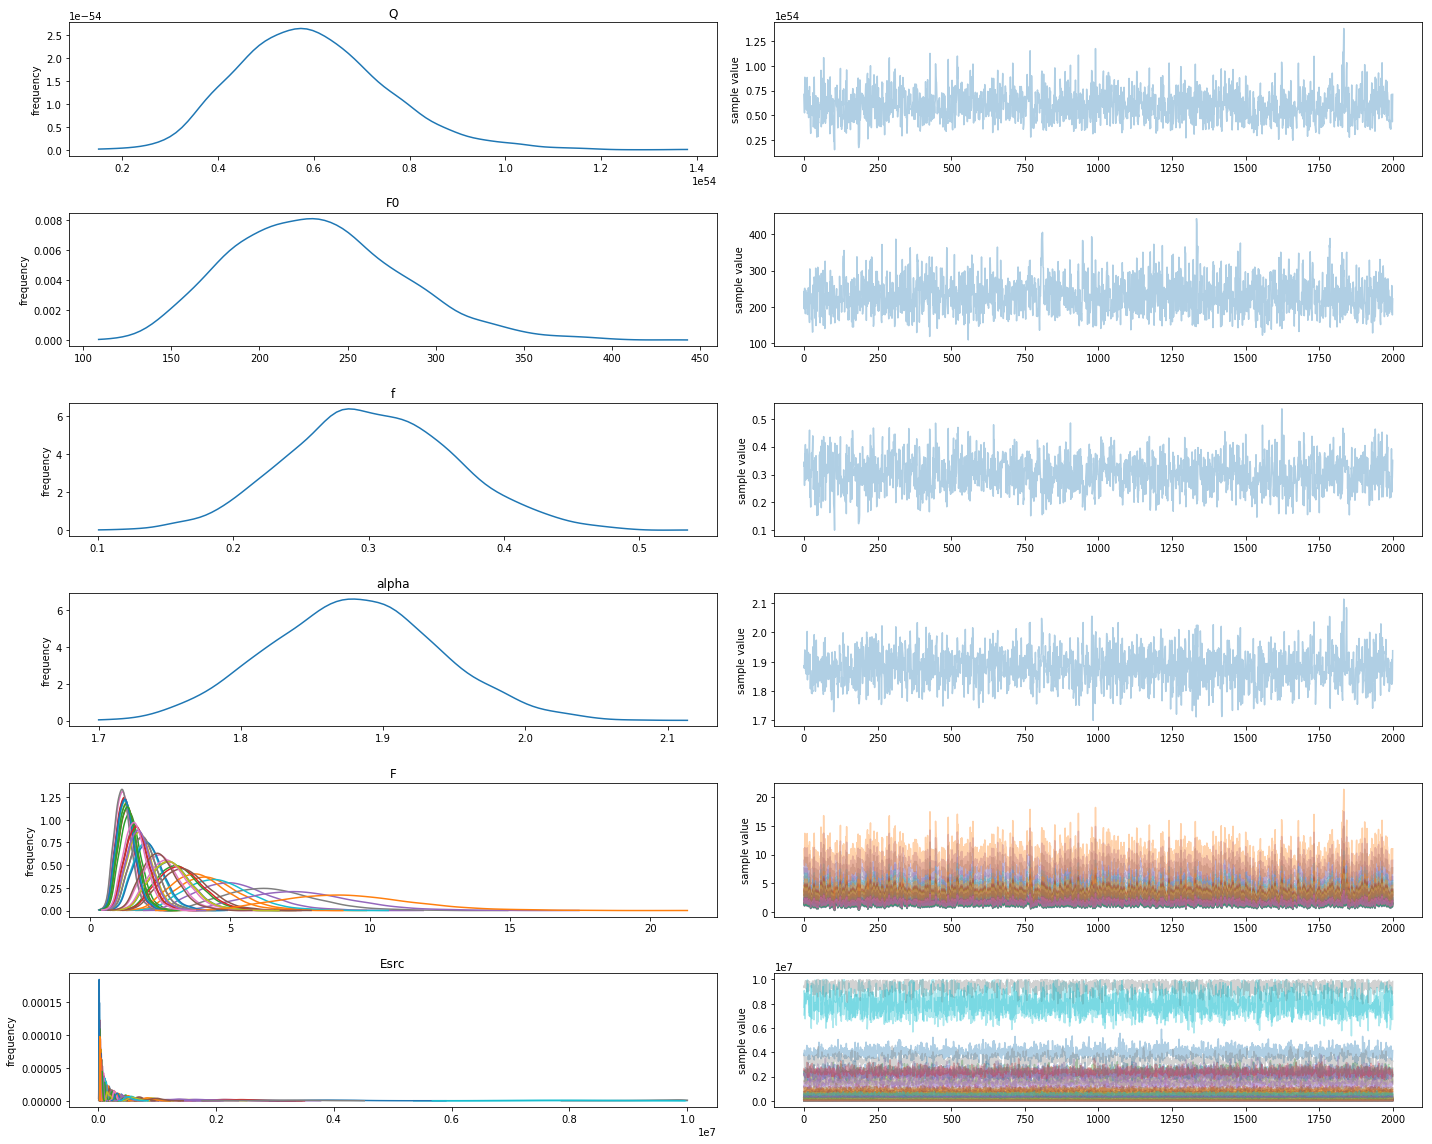

In [29]:
# View chains
fig = fit.plot([r'Q', r'F0', r'f', r'alpha', r'F', r'Esrc']);
fig.set_size_inches(20, 16)
fig.tight_layout()

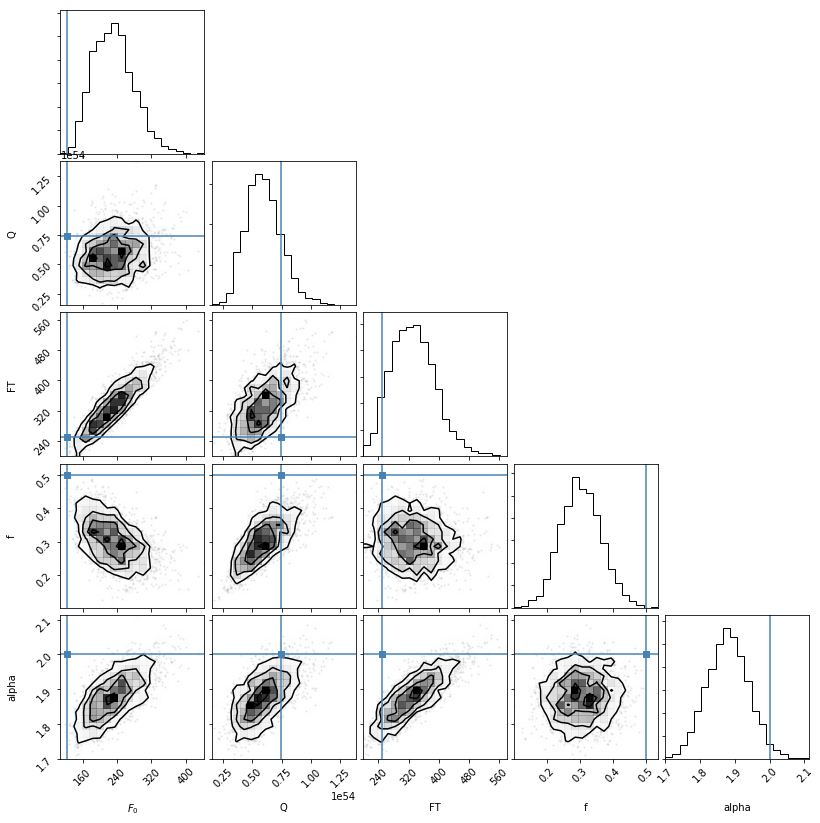

In [30]:
# View corner plot
chain = fit.extract(permuted = True)
key_list = ['F0', 'Q', 'FT', 'f', 'alpha']
labels = [r'$F_0$', r'Q', r'FT', r'f', 'alpha']
truths = [sim_input['F0'] * E_scale , sim_input['Q'] * E_scale, total_flux * E_scale, f, sim_input['alpha']]

corner.corner(np.nan_to_num(np.column_stack([chain[key] for key in key_list])),
              labels = labels, 
              truths = truths);

## Association probabilities

In [ ]:
logprob = chain['lp'].transpose(1, 2, 0)
N = np.shape(logprob)[0]

# Account for background component
Ns = np.shape(logprob)[1] - 1

In [ ]:
# Calculate association probabilities for each source-neutrino combo
nu_p = []
for lp in logprob:
    lps = []
    for src in range(Ns+1):
        lps.append(np.mean(np.exp(lp[src])))

    norm = sum(lps)
    ps = []
    for src in range(Ns+1):
        ps.append(lps[src] / norm)
    nu_p.append(ps)

# Normalise line weights
pmax = max(max(nu_p))

In [ ]:
# Figure
fig, ax = plt.subplots()
fig.set_size_inches((12, 6))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);

# Sources
for r, d in zip(s_ra, s_dec):
    skymap.tissot(np.rad2deg(r), np.rad2deg(d), 2, 30, color = 'black')
    
# Neutrinos
for r, d, l in zip(e_ra, e_dec, lam):
    color = label_cmap.colors[int(l)]
    skymap.tissot(np.rad2deg(r), np.rad2deg(d), 2, 30, color = color, alpha = 0.7)
    
# Association
for i, p in enumerate(nu_p):
    for j, psrc in enumerate(p[0:Ns]):
        if psrc > 0.001:
            skymap.geodesic(np.rad2deg(e_ra[i]), np.rad2deg(e_dec[i]), 
                            np.rad2deg(s_ra[j]), np.rad2deg(s_dec[j]), 
                            color = 'black', lw = 3, alpha = psrc/pmax, zorder = 10)